# Implementation of the MoCo algorithm with training the encoder and after the clasification_head

**The encoder can be pretrained using an unsupervised way. It is after trained using the SimCLR algorithm and the classification head is trained by supervised learning**

**MoCo v2 uses a deeper MLP as a projection_head, a larger dimension of the projection space and uses blur augmentation**

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models, regularizers

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa.display

import matplotlib.pyplot as plt

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

from dpmhm.datasets import preprocessing, feature, utils, transformer

ds_all, ds_info = tfds.load(
    'CWRU',
    with_info=True,
)

ds0 = ds_all['train']
ds0.element_spec

2024-06-13 13:25:03.640042: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:25:03.644839: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:25:03.704385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 13:25:04.671162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-13 13:25:06.795690: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-13 13:25:06.795742: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] ret

{'metadata': {'Dataset': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

Preprocessing on data

In [2]:
compactor = transformer.DatasetCompactor(ds0,
                                         channels=['DE', 'FE', 'BA'],
                                         keys=['FaultLocation', 'FaultComponent', 'FaultSize'],
                                         resampling_rate=12000)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram',
#                                                 n_mfcc=256,
                                                time_window=0.025, hop_step=0.0125, n_fft=512,
                                                normalize=False, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
# window = transformer.WindowSlider(extractor.dataset, window_size=(256, 80), hop_size=40)  # 1s, full bandwidth
# window = transformer.WindowSlider(extractor.dataset, window_size=64, hop_size=32)

labels = list(compactor.full_label_dict.keys())

preproc = preprocessing.get_mapping_supervised(labels)
    
ds_window = window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)

eles = list(ds_window.take(10).as_numpy_iterator())
input_shape = eles[0][0].shape

ds_window = ds_window.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)

splits = {'train':0.7, 'val':0.2, 'test':0.1}
ds_split = utils.split_dataset(ds_window, splits, ds_size=int(ds_window.cardinality()))

2024-06-13 13:25:09.158267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:09.516813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:09.894217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:10.473134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:10.947126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:20.158514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:20.172542: W tensorflow/core/framework/local_rendezvous.cc:404] L

Parameters

In [3]:
batch_size = 32
ds_size = sum([1 for _ in ds_window])
n_embedding  = 128 
kernel_size = (3,3) 
tau = 0.1
projection_dim = 528
momentum_coeff=0.99
queue_size=10000

2024-06-13 13:25:29.028837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 13:25:29.044987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Creation of the encoder

In [4]:
tf.config.run_functions_eagerly(True)

@keras.utils.register_keras_serializable()
class Autoencoder(models.Model):
    """Convolution Auto-Encoder stacks.


    Notes
    -----
    Shape (H,W) of the input tensor must be power of 2.
    """
    def __init__(self, input_shape, n_embedding,kernel_size):
        self.input_shape = input_shape
        activation = 'relu'
        padding = 'same'
        strides = (2,2)
        pool_size = (2,2)
        a_reg = 0. 

        super(Autoencoder, self).__init__()

        # Use more blocks and larger kernel size to get more smoothing in the reconstruction.
        input_layer= layers.Input(shape=input_shape, name='input_enc')

        layers_encoder = [
            # Block 1
            layers.Conv2D(32, kernel_size=kernel_size, activation=activation, padding=padding, name='conv1_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool1_enc'),
            layers.BatchNormalization(name='bn1_enc'), # by default axis=-1 for channel-last

            # Block 2
            layers.Conv2D(64, kernel_size=kernel_size, activation=activation, padding=padding, name='conv2_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool2_enc'),
            layers.BatchNormalization(name='bn2_enc'),

            # Block 3
            layers.Conv2D(128, kernel_size=kernel_size, activation=activation, padding=padding, name='conv3_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool3_enc'),
            layers.BatchNormalization(name='bn3_enc'),

            # Block fc
            layers.Flatten(name='flatten'),
            layers.Dense(n_embedding, activation=activation,activity_regularizer=regularizers.L1(a_reg), name='fc1_enc') if a_reg > 0
            else layers.Dense(n_embedding, activation=activation, name='fc1_enc')
        ]

        self.encoder = models.Sequential([input_layer] +layers_encoder, name='encoder')

        output_layer = layers.Input(shape=(n_embedding,), name='input_dec')
        layers_decoder = [
            # Block fc
            layers.Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), activation=activation, activity_regularizer=regularizers.L1(a_reg), name='fc1_dec') if a_reg > 0 else layers.Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), activation=activation, name='fc1_dec'),
            layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128), name='reshape'),

            # Block 3
            layers.BatchNormalization(name='bn3_dec'),
            layers.UpSampling2D(strides, name='ups3_dec'),
            layers.Conv2DTranspose(64, kernel_size=kernel_size, activation=activation, padding=padding, name='tconv3_dec'),

            # Block 2
            layers.BatchNormalization(name='bn2_dec'),
            layers.UpSampling2D(strides, name='ups2_dec'),
            layers.Conv2DTranspose(32, kernel_size=kernel_size, activation=activation, padding=padding, name='tconv2_dec'),

            # Block 1
            layers.BatchNormalization(name='bn1_dec'),
            layers.UpSampling2D(strides, name='ups1_dec'),
            layers.Conv2DTranspose(input_shape[-1], kernel_size=kernel_size, activation=None, padding=padding, name='tconv1_dec'),
        ]

        self.decoder = models.Sequential([output_layer] + layers_decoder, name='decoder')
        # self.decoder.build()

        self.autoencoder = models.Sequential([input_layer] + layers_encoder + layers_decoder, name='auto-encoder')
        # self.build(input_shape=(None, *input_shape))

    def call(self, x):
        return self.decoder(self.encoder(x))

autoencoder = Autoencoder(input_shape,n_embedding,kernel_size)

Definition of the MoCo model

In [5]:
import cv2
import numpy as np

class RandomGaussianBlur(layers.Layer):
    def __init__(self, kernel_size=(5, 5), sigma_range=(0.1, 2.0), **kwargs):
        super(RandomGaussianBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma_range = sigma_range

    def build(self, input_shape):
        # Create a gaussian kernel placeholder
        self.kernel = self.add_weight(
            name='kernel',
            shape=self.kernel_size + (input_shape[-1], 1),
            initializer='zeros',
            trainable=False,
        )

    def call(self, x):
        # Generate a random sigma value
        sigma = tf.random.uniform([], self.sigma_range[0], self.sigma_range[1])
        
        # Create Gaussian kernel
        x_range = tf.range(-self.kernel_size[0] // 2 + 1, self.kernel_size[0] // 2 + 1, dtype=tf.float32)
        y_range = tf.range(-self.kernel_size[1] // 2 + 1, self.kernel_size[1] // 2 + 1, dtype=tf.float32)
        xv, yv = tf.meshgrid(x_range, y_range)
        gaussian_kernel = tf.exp(-(xv**2 + yv**2) / (2.0 * sigma**2))
        gaussian_kernel = gaussian_kernel / tf.reduce_sum(gaussian_kernel)
        gaussian_kernel = gaussian_kernel[:, :, tf.newaxis, tf.newaxis]
        
        # Apply Gaussian blur
        gaussian_kernel = tf.tile(gaussian_kernel, [1, 1, x.shape[-1], 1])
        x = tf.nn.depthwise_conv2d(x, gaussian_kernel, strides=[1, 1, 1, 1], padding='SAME')
        
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

class MoCo(keras.Model):
    def __init__(self,momentum_coeff,temperature,queue_size):
        super().__init__()

        self.contrastive_augmenter = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomZoom(0.2),
            layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
            RandomGaussianBlur(kernel_size=(5, 5), sigma_range=(0.1, 0.7)),
        ], name='Data_augmentation')

        self.encoder = autoencoder.encoder

        self.projection_head = keras.Sequential([
                layers.Dense(256, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(128, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(projection_dim),
            ], name='Projection_head')
        
        self.classification_head = keras.Sequential([
                layers.Dense(128, activation='relu', input_shape=(128,)),
                layers.BatchNormalization(),
                layers.Dense(30) #nb labels
            ], name='Classification_head')
        
        self.momentum_coeff = momentum_coeff
        self.temperature = temperature

        # the momentum networks are initialized from their online counterparts
        self.m_encoder = keras.models.clone_model(self.encoder)
        self.m_projection_head = keras.models.clone_model(self.projection_head)

        # feature_dimensions = self.encoder.output_shape[1]
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, projection_dim)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()

    def reset_metrics(self):
        self.contrastive_accuracy.reset_state()
        self.probe_accuracy.reset_state()

    def update_contrastive_accuracy(self, features_1, features_2):
        # self-supervised metric inspired by the SimCLR loss

        # cosine similarity: the dot product of the l2-normalized feature vectors
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        # the similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )
    
    def cosine_similarity(features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)
        return similarities

    def contrastive_loss(self, query, key):
        # similar to the SimCLR loss, however it uses the momentum networks'
        # representations of the differently augmented views as targets
        query = tf.math.l2_normalize(query, axis=1)
        key = tf.math.l2_normalize(key, axis=1)

        similarities = (
            tf.matmul(
                query,
                tf.concat((key, self.feature_queue), axis=0),
                transpose_b=True,
            )
            / self.temperature
        )

        batch_size = tf.shape(query)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat([contrastive_labels], axis=0),
            tf.concat([similarities], axis=0),
            from_logits=True,
        )

        # feature queue update
        self.feature_queue.assign(
            tf.concat(
                [
                    key,
                    self.feature_queue[: -batch_size],
                ],
                axis=0,
            )[:self.feature_queue.shape[0]]
        )
        return tf.reduce_mean(loss)

    @tf.function
    def train_step(self, data):
        train_image, _ = data

        augmented_image = self.contrastive_augmenter(train_image)
        with tf.GradientTape() as tape:
            features = self.encoder(train_image)
            query = self.projection_head(features)
        
            m_features = self.m_encoder(augmented_image)
            key = self.m_projection_head(m_features)
            contrastive_loss = self.contrastive_loss(query, key)

        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,)

        self.contrastive_optimizer.apply_gradients(
            zip(gradients,self.encoder.trainable_weights + self.projection_head.trainable_weights,))
        
        self.update_contrastive_accuracy(query, key)

        # the momentum networks are updated by exponential moving average
        for weight, m_weight in zip(self.encoder.weights, self.m_encoder.weights):
            m_weight.assign(
                self.momentum_coeff * m_weight + (1 - self.momentum_coeff) * weight
            )
        for weight, m_weight in zip(
            self.projection_head.weights, self.m_projection_head.weights
        ):
            m_weight.assign(
                self.momentum_coeff * m_weight + (1 - self.momentum_coeff) * weight
            )

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
        }

    def test_step(self, data):
        test_image, _ = data
        augmented_image = self.contrastive_augmenter(test_image)
        
        features = self.encoder(test_image)
        query = self.projection_head(features)
    
        m_features = self.m_encoder(augmented_image)
        key = self.m_projection_head(m_features)
        self.update_contrastive_accuracy(query, key)

        return {
            "c_acc": self.contrastive_accuracy.result(),
        }

Train the MoCo model

In [6]:
MoCo_model = MoCo(momentum_coeff, tau, queue_size)
     
MoCo_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size,drop_remainder=True)
ds_test = ds_split['test'].batch(1)

history = MoCo_model.fit(ds_train.repeat(), epochs=20, validation_data=ds_val, steps_per_epoch=int((0.7*ds_size) // batch_size))

Epoch 1/20


/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-13 13:25:34.263950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - c_acc: 0.0312 - c_loss: 5.6694

2024-06-13 13:28:13.192180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 177s 482ms/step - c_acc: 0.0312 - c_loss: 5.6695 - val_c_acc: 0.0733
Epoch 2/20


2024-06-13 13:28:26.096197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - c_acc: 0.0969 - c_loss: 5.2224

2024-06-13 13:31:02.626010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 169s 475ms/step - c_acc: 0.0969 - c_loss: 5.2226 - val_c_acc: 0.1584
Epoch 3/20


2024-06-13 13:31:15.178681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - c_acc: 0.1832 - c_loss: 4.9789

2024-06-13 13:33:56.621093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 174s 490ms/step - c_acc: 0.1833 - c_loss: 4.9779 - val_c_acc: 0.3342
Epoch 4/20


2024-06-13 13:34:09.512627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - c_acc: 0.3807 - c_loss: 4.6344

2024-06-13 13:36:45.591680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 169s 475ms/step - c_acc: 0.3808 - c_loss: 4.6336 - val_c_acc: 0.4638
Epoch 5/20


2024-06-13 13:36:58.595578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - c_acc: 0.4968 - c_loss: 4.3886

2024-06-13 13:39:33.726886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 168s 471ms/step - c_acc: 0.4968 - c_loss: 4.3884 - val_c_acc: 0.5648
Epoch 6/20


2024-06-13 13:39:46.231333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - c_acc: 0.5420 - c_loss: 4.2401

2024-06-13 13:42:22.754752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 477ms/step - c_acc: 0.5421 - c_loss: 4.2395 - val_c_acc: 0.6187
Epoch 7/20


2024-06-13 13:42:35.826376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - c_acc: 0.6294 - c_loss: 4.1093

2024-06-13 13:45:15.884820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 174s 488ms/step - c_acc: 0.6294 - c_loss: 4.1090 - val_c_acc: 0.6679
Epoch 8/20


2024-06-13 13:45:29.446590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - c_acc: 0.6489 - c_loss: 3.9805

2024-06-13 13:48:05.783955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 169s 476ms/step - c_acc: 0.6489 - c_loss: 3.9803 - val_c_acc: 0.6281
Epoch 9/20


2024-06-13 13:48:18.854501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - c_acc: 0.6639 - c_loss: 3.9030

2024-06-13 13:50:56.493969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 171s 481ms/step - c_acc: 0.6639 - c_loss: 3.9023 - val_c_acc: 0.6822
Epoch 10/20


2024-06-13 13:51:10.148825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - c_acc: 0.6867 - c_loss: 3.8895

2024-06-13 13:53:54.833172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 178s 500ms/step - c_acc: 0.6868 - c_loss: 3.8896 - val_c_acc: 0.6890
Epoch 11/20


2024-06-13 13:54:07.924905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - c_acc: 0.6992 - c_loss: 3.8371

2024-06-13 13:56:46.585111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 173s 485ms/step - c_acc: 0.6992 - c_loss: 3.8373 - val_c_acc: 0.7104
Epoch 12/20


2024-06-13 13:57:00.744192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - c_acc: 0.7200 - c_loss: 3.7711

2024-06-13 13:59:43.646334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 176s 496ms/step - c_acc: 0.7200 - c_loss: 3.7711 - val_c_acc: 0.7085
Epoch 13/20


2024-06-13 13:59:57.217588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - c_acc: 0.7122 - c_loss: 3.7715

2024-06-13 14:02:39.300823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 176s 494ms/step - c_acc: 0.7122 - c_loss: 3.7711 - val_c_acc: 0.7359
Epoch 14/20


2024-06-13 14:02:53.118055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - c_acc: 0.7370 - c_loss: 3.7314

2024-06-13 14:05:35.881489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 176s 495ms/step - c_acc: 0.7371 - c_loss: 3.7311 - val_c_acc: 0.7112
Epoch 15/20


2024-06-13 14:05:49.380025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - c_acc: 0.7369 - c_loss: 3.6678

2024-06-13 14:08:28.680607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 172s 484ms/step - c_acc: 0.7370 - c_loss: 3.6676 - val_c_acc: 0.7599
Epoch 16/20


2024-06-13 14:08:41.555272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - c_acc: 0.7405 - c_loss: 3.6948

2024-06-13 14:11:18.949664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 478ms/step - c_acc: 0.7405 - c_loss: 3.6946 - val_c_acc: 0.7718
Epoch 17/20


2024-06-13 14:11:31.698880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - c_acc: 0.7443 - c_loss: 3.6889

2024-06-13 14:14:11.081796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 173s 485ms/step - c_acc: 0.7444 - c_loss: 3.6883 - val_c_acc: 0.7650
Epoch 18/20


2024-06-13 14:14:24.301654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - c_acc: 0.7464 - c_loss: 3.6721

2024-06-13 14:17:07.615319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 176s 495ms/step - c_acc: 0.7464 - c_loss: 3.6719 - val_c_acc: 0.7500
Epoch 19/20


2024-06-13 14:17:20.609322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - c_acc: 0.7636 - c_loss: 3.6514

2024-06-13 14:19:58.690876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 170s 479ms/step - c_acc: 0.7636 - c_loss: 3.6514 - val_c_acc: 0.7726
Epoch 20/20


2024-06-13 14:20:11.007940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - c_acc: 0.7663 - c_loss: 3.6663

2024-06-13 14:22:48.410361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 171s 480ms/step - c_acc: 0.7663 - c_loss: 3.6666 - val_c_acc: 0.7650


2024-06-13 14:23:01.789291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Print evolution of metrics

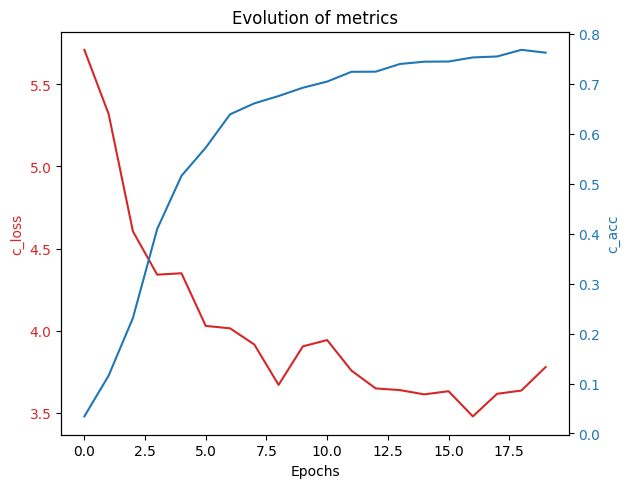

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('c_loss', color=color)
ax1.plot(history.history['c_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('c_acc', color=color) 
ax2.plot(history.history['c_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Evolution of metrics')
plt.show()

Define the classification model and train the classification head

In [8]:
# Freeze the encoder weights
MoCo_model.encoder.trainable = False

# Create a new classification model
encoder_output = MoCo_model.encoder(MoCo_model.encoder.layers[0].input)
classification_model = keras.Model(
    inputs=MoCo_model.encoder.layers[0].input,
    outputs=MoCo_model.classification_head(encoder_output)
)
classification_model.summary(show_trainable=True, expand_nested=True)

classification_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

classification_history = classification_model.fit(ds_train.repeat(), epochs=10, validation_data=ds_val, steps_per_epoch=int((0.7*ds_size) // batch_size))

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_enc (InputLayer)      │ (None, 64, 64, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ encoder (Sequential)        │ (None, 128)           │  1,142,848 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv1_enc (Conv2D)     │ (None, 64, 64, 32)    │        896 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool1_enc              │ (None, 32, 32, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn1_enc                │ (None, 32, 32, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2_enc (Conv2D)     │ (None, 32, 32, 64)    │     18,496 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool2_enc              │ (None, 16, 16, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn2_enc                │ (None, 16, 16, 64)    │        256 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv3_enc (Conv2D)     │ (None, 16, 16, 128)   │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool3_enc              │ (None, 8, 8, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn3_enc                │ (None, 8, 8, 128)     │        512 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ flatten (Flatten)      │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ fc1_enc (Dense)        │ (None, 128)           │  1,048,704 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Classification_head         │ (None, 30)            │     20,894 │   Y   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_3 (Dense)        │ (None, 128)           │     16,512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_2  │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_4 (Dense)        │ (None, 30)            │      3,870 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,163,742 (4.44 MB)

 Trainable params: 20,638 (80.62 KB)

 Non-trainable params: 1,143,104 (4.36 MB)

Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2584 - loss: 2.6665

2024-06-13 14:24:03.577608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 186ms/step - accuracy: 0.2589 - loss: 2.6648 - val_accuracy: 0.6556 - val_loss: 1.3623
Epoch 2/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.5312 - loss: 1.3537

2024-06-13 14:24:08.626059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6811 - loss: 1.1360

2024-06-13 14:25:11.728492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 68s 191ms/step - accuracy: 0.6813 - loss: 1.1356 - val_accuracy: 0.8332 - val_loss: 0.7249
Epoch 3/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 57s 161ms/step - accuracy: 0.7812 - loss: 0.7672

2024-06-13 14:25:16.746959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8244 - loss: 0.6619

2024-06-13 14:26:18.475308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 67s 188ms/step - accuracy: 0.8244 - loss: 0.6616 - val_accuracy: 0.8923 - val_loss: 0.4944
Epoch 4/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 1:03 178ms/step - accuracy: 0.8750 - loss: 0.5084

2024-06-13 14:26:23.574761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8923 - loss: 0.4353

2024-06-13 14:27:25.918946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 67s 189ms/step - accuracy: 0.8923 - loss: 0.4352 - val_accuracy: 0.9084 - val_loss: 0.3500
Epoch 5/10


2024-06-13 14:27:30.989965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9131 - loss: 0.3303

2024-06-13 14:28:32.502232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 187ms/step - accuracy: 0.9131 - loss: 0.3302 - val_accuracy: 0.9344 - val_loss: 0.2583
Epoch 6/10


2024-06-13 14:28:37.467263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9366 - loss: 0.2471

2024-06-13 14:29:38.664549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 186ms/step - accuracy: 0.9366 - loss: 0.2470 - val_accuracy: 0.9527 - val_loss: 0.1950
Epoch 7/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 1.0000 - loss: 0.1690

2024-06-13 14:29:43.799370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9486 - loss: 0.2051

2024-06-13 14:30:44.457788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.9487 - loss: 0.2051 - val_accuracy: 0.9585 - val_loss: 0.1690
Epoch 8/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 0.9688 - loss: 0.1402

2024-06-13 14:30:49.324985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9515 - loss: 0.1857

2024-06-13 14:31:50.207648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 185ms/step - accuracy: 0.9515 - loss: 0.1857 - val_accuracy: 0.9629 - val_loss: 0.1408
Epoch 9/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 1.0000 - loss: 0.0912

2024-06-13 14:31:55.123895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9638 - loss: 0.1460

2024-06-13 14:32:55.653020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.9638 - loss: 0.1460 - val_accuracy: 0.9737 - val_loss: 0.1100
Epoch 10/10
  1/356 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.9688 - loss: 0.0985

2024-06-13 14:33:00.519755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9692 - loss: 0.1239

2024-06-13 14:34:02.356937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - accuracy: 0.9693 - loss: 0.1239 - val_accuracy: 0.9607 - val_loss: 0.3775


2024-06-13 14:34:07.194427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Evaluate the model

In [9]:
evaluation = classification_model.evaluate(ds_test)

# Print the evaluation metrics
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy: {:.2f}%".format(evaluation[1]*100))

      6/Unknown 5s 24ms/step - accuracy: 1.0000 - loss: 0.0085

2024-06-13 14:34:12.112535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1630/1630 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9639 - loss: 0.1405
Evaluation Loss: 0.13674744963645935
Evaluation Accuracy: 96.38%


2024-06-13 14:34:46.005529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
